In [4]:
import pandas as pd
import os
import numpy as np
import csv
from matplotlib import pyplot as plt

import pydicom
import glob
import natsort
import cv2

import scipy.ndimage
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from sklearn.model_selection import train_test_split
from PIL import Image

import keras
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, GlobalAveragePooling2D
from keras.applications import resnet50, inception_v3, vgg16
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.optimizers import Adam, SGD
import tensorflow as tf
from sklearn.decomposition import PCA

import pickle

Using TensorFlow backend.


# Load Scans

In [5]:
# sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1

In [6]:
def make_X_flat(new_dcm, y):
    X = []
    Y = []
    paths = []
    for i, filepath in enumerate(new_dcm):
        pt = []
        dcm_files = dcm_dict[filepath]

        temp = []
        for file in dcm_files:
            ds = pydicom.read_file(file)
            temp.append(ds)

        temp = sorted(temp, key=lambda d: d.SliceLocation)
        start = int(3 * len(temp)/ 10)
        end = start + 10
#         temp = temp[:20]
        temp = temp[start : end]
        

        for ds in temp:
            arr = ds.pixel_array
            new = cv2.resize(arr, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
            X.append(new)
            Y.append(y[i])
#             new_flipped = np.fliplr(new)
#             X.append(new_flipped)
#             Y.append(y[i])
            paths.append(filepath)
        print(i, filepath, y[i])

    return X, Y, paths

In [7]:
with open('dcm_scans_filtered.pickle', 'rb') as handle:
    dcm = pickle.load(handle)

new_dcm = dcm['X']
y = dcm['Y']

In [8]:
with open('dcm_scans_filtered.pickle', 'rb') as handle:
    dcm = pickle.load(handle)

new_dcm = dcm['X']
y = dcm['Y']

In [9]:
with open('dcm_scans.pickle', 'rb') as handle:
    dcm_scans = pickle.load(handle)
    
dcm_dict = dcm_scans['paths']
dcm_ys = dcm_scans['y']

In [10]:
with open('dcm_stage_scans_filtered.pickle', 'rb') as handle:
    dcm_scans = pickle.load(handle)
    
dcm_stage_dict = dcm_scans['X']
dcm_stage_ys = dcm_scans['Y']

In [11]:
sum(dcm_stage_ys), len(dcm_stage_ys)

(722, 665)

In [12]:
dcm_stage_X, dcm_stage_Y, dcm_stage_paths = make_X_flat(dcm_stage_dict, dcm_stage_ys)

0 ../ppmi/cd-pd/PPMI/3220/Ax_T2_FLAIR/2011-12-01_07_26_14.0/S139712 1
1 ../ppmi/cd-pd/PPMI/3111/Axial_PD-T2_TSE/2011-05-26_13_20_29.0/S113786 1
2 ../ppmi/cd-pd/PPMI/3230/Ax_T2_FLAIR/2012-07-18_10_28_29.0/S189279 1
3 ../ppmi/cd-pd/PPMI/3320/Axial_PD-T2_TSE_AC_PC_line/2012-05-31_14_08_42.0/S157091 0
4 ../ppmi/cd-pd/PPMI/3459/sT2W_PD_TSE/2011-05-16_14_29_13.0/S128037 1
5 ../ppmi/cd-pd/PPMI/3472/sT2W_PD_TSE/2012-06-19_11_06_16.0/S158352 1
6 ../ppmi/cd-pd/PPMI/3851/Axial_PD-T2_TSE_FS/2013-04-12_08_51_45.0/S203201 0
7 ../ppmi/cd-pd/PPMI/3851/Axial_PD-T2_TSE/2011-04-13_08_18_19.0/S204362 0
8 ../ppmi/cd-pd/PPMI/3360/Axial_PD-T2_TSE_FS/2015-04-29_08_32_35.0/S264321 2
9 ../ppmi/cd-pd/PPMI/3360/Axial_PD-T2_TSE_FS/2013-07-31_08_57_43.0/S203304 2
10 ../ppmi/cd-pd/PPMI/3360/Axial_PD-T2_TSE/2012-06-07_08_12_12.0/S157069 2
11 ../ppmi/cd-pd/PPMI/3360/Axial_PD-T2_TSE/2011-04-18_10_52_24.0/S117963 2
12 ../ppmi/cd-pd/PPMI/3957/Ax_PD__T2/2012-06-27_08_23_57.0/S184909 1
13 ../ppmi/cd-pd/PPMI/3586/Axial_PD-T

108 ../ppmi/cd-pd/PPMI/3601/AX_PD_+_T2/2011-03-24_13_10_07.0/S102937 2
109 ../ppmi/cd-pd/PPMI/3020/AX_T2_AC-PC_line_Entire_Brain/2012-04-21_11_15_54.0/S148895 2
110 ../ppmi/cd-pd/PPMI/3479/sT2W_PD_TSE/2013-01-02_10_17_24.0/S183660 0
111 ../ppmi/cd-pd/PPMI/3301/Axial_PD-T2_TSE_AC_PC_line/2012-02-16_16_23_16.0/S149021 0
112 ../ppmi/cd-pd/PPMI/3301/Axial_PD-T2_TSE_FS/2013-04-18_11_16_15.0/S193455 0
113 ../ppmi/cd-pd/PPMI/3301/Axial_PD-T2_TSE_FS/2015-03-18_13_18_54.0/S264315 0
114 ../ppmi/cd-pd/PPMI/3218/Ax_T2_FLAIR/2011-10-17_12_12_29.0/S139706 2
115 ../ppmi/cd-pd/PPMI/3012/AX_T2_AC-PC_line_Entire_Brain/2011-11-22_15_42_05.0/S147144 2
116 ../ppmi/cd-pd/PPMI/3471/sT2W_PD_TSE/2012-02-28_13_04_49.0/S170951 2
117 ../ppmi/cd-pd/PPMI/4011/AXIAL_PD-T2_TSE_FS/2016-02-11_10_55_58.0/S446253 1
118 ../ppmi/cd-pd/PPMI/4011/Axial_PD-T2_TSE_FS/2014-01-16_10_02_19.0/S212799 1
119 ../ppmi/cd-pd/PPMI/4011/Axial_PD-T2_TSE_FS/2012-12-06_11_17_43.0/S208540 1
120 ../ppmi/cd-pd/PPMI/3328/Axial_PD-T2_TSE_AC_PC_l

214 ../ppmi/cd-pd/PPMI/3779/Axial_PD-T2_TSE/2012-06-13_09_30_57.0/S160423 0
215 ../ppmi/cd-pd/PPMI/3800/Axial_PD-T2_TSE_FS/2013-03-19_11_35_35.0/S203323 2
216 ../ppmi/cd-pd/PPMI/3800/Axial_PD-T2_TSE_FS/2015-04-21_11_08_44.0/S263096 2
217 ../ppmi/cd-pd/PPMI/3800/Axial_PD-T2_TSE/2011-03-15_12_35_25.0/S131535 2
218 ../ppmi/cd-pd/PPMI/3203/Ax_T2_FLAIR/2011-01-06_12_34_23.0/S101871 1
219 ../ppmi/cd-pd/PPMI/3006/AX_T2_AC-PC_line_Entire_Brain/2011-05-10_17_47_53.0/S113521 2
220 ../ppmi/cd-pd/PPMI/3835/Axial_PD-T2_TSE_FS/2017-01-31_11_34_11.0/S648866 1
221 ../ppmi/cd-pd/PPMI/3835/Axial_PD-T2_TSE_FS/2014-01-28_10_57_14.0/S213521 1
222 ../ppmi/cd-pd/PPMI/3835/Axial_PD-T2_TSE_FS/2015-02-03_11_01_04.0/S250434 1
223 ../ppmi/cd-pd/PPMI/3835/Axial_PD-T2_TSE/2013-01-22_11_37_46.0/S189949 1
224 ../ppmi/cd-pd/PPMI/3216/Ax_T2_FLAIR/2011-08-26_10_09_54.0/S139703 0
225 ../ppmi/cd-pd/PPMI/3668/PD-T2_DUAL_AXIAL_TSE/2013-05-09_10_33_23.0/S189288 0
226 ../ppmi/cd-pd/PPMI/3660/PD-T2_DUAL_AXIAL_TSE/2012-03-16_08

321 ../ppmi/cd-pd/PPMI/4034/Axial_PD-T2_TSE_FS/2013-04-02_09_57_23.0/S187109 1
322 ../ppmi/cd-pd/PPMI/3209/Ax_T2_FLAIR/2011-07-27_11_12_00.0/S189262 2
323 ../ppmi/cd-pd/PPMI/3260/AX_T2_DE/2011-05-27_10_45_19.0/S113542 0
324 ../ppmi/cd-pd/PPMI/3215/Ax_T2_FSE/2011-08-18_13_40_02.0/S190599 0
325 ../ppmi/cd-pd/PPMI/3221/Ax_T2_FLAIR/2011-12-08_08_11_59.0/S139716 0
326 ../ppmi/cd-pd/PPMI/3221/Axial_PD-T2_TSE_FS/2016-06-16_13_29_42.0/S484604 0
327 ../ppmi/cd-pd/PPMI/3819/Axial_PD-T2_TSE_FS/2014-03-25_10_35_33.0/S228224 1
328 ../ppmi/cd-pd/PPMI/3819/Axial_PD-T2_TSE_FS/2016-04-12_11_09_01.0/S426416 1
329 ../ppmi/cd-pd/PPMI/3819/Axial_PD-T2_TSE_FS/2013-04-09_10_03_54.0/S204519 1
330 ../ppmi/cd-pd/PPMI/3819/Axial_PD-T2_TSE/2012-04-17_11_36_16.0/S151346 1
331 ../ppmi/cd-pd/PPMI/3182/Axial_PD-T2-FS_TSE/2016-08-19_10_46_59.0/S501584 2
332 ../ppmi/cd-pd/PPMI/3182/Axial_PD-T2_TSE/2013-07-19_11_08_16.0/S203265 2
333 ../ppmi/cd-pd/PPMI/3574/Axial_PD-T2_TSE_FS/2015-10-01_10_16_34.0/S331807 2
334 ../ppmi/

429 ../ppmi/cd-pd/PPMI/3174/Axial_PD-T2_TSE/2012-04-12_10_45_48.0/S151264 1
430 ../ppmi/cd-pd/PPMI/3174/Axial_PD-T2_TSE/2013-04-09_10_58_50.0/S188380 1
431 ../ppmi/cd-pd/PPMI/3357/Axial_PD-T2_TSE_FS/2015-08-19_09_38_22.0/S277078 0
432 ../ppmi/cd-pd/PPMI/3357/Axial_PD-T2_TSE/2011-03-24_08_10_02.0/S117957 0
433 ../ppmi/cd-pd/PPMI/3357/Axial_PD-T2_TSE/2012-03-19_11_57_34.0/S146650 0
434 ../ppmi/cd-pd/PPMI/4082/Axial_PD-T2_TSE_FS/2014-03-11_08_57_35.0/S217935 2
435 ../ppmi/cd-pd/PPMI/4082/Axial_PD-T2_TSE_FS/2013-01-21_13_34_00.0/S181391 2
436 ../ppmi/cd-pd/PPMI/4082/Axial_PD-T2_TSE_FS/2017-02-20_13_22_36.0/S606343 2
437 ../ppmi/cd-pd/PPMI/4082/Axial_PD-T2_TSE_FS/2015-02-23_07_32_03.0/S308755 2
438 ../ppmi/cd-pd/PPMI/3664/PD-T2_DUAL_AXIAL_TSE/2013-02-25_11_28_17.0/S184908 1
439 ../ppmi/cd-pd/PPMI/3134/Axial_PD-T2_TSE_FS/2013-04-22_09_22_01.0/S188146 1
440 ../ppmi/cd-pd/PPMI/3134/Axial_PD-T2_TSE_FS/2017-04-14_12_14_23.0/S606237 1
441 ../ppmi/cd-pd/PPMI/3134/Axial_PD-T2_TSE_FS/2014-05-07_11_3

535 ../ppmi/cd-pd/PPMI/3270/AX_T2_DE/2011-09-16_12_45_44.0/S124921 1
536 ../ppmi/cd-pd/PPMI/4136/Axial_PD-T2_TSE_FS/2014-05-06_13_49_47.0/S225642 2
537 ../ppmi/cd-pd/PPMI/4136/Axial_PD-T2_TSE_FS/2013-02-28_08_50_55.0/S193239 2
538 ../ppmi/cd-pd/PPMI/3201/Ax_T2_FLAIR/2010-12-02_10_58_37.0/S101956 0
539 ../ppmi/cd-pd/PPMI/3824/Axial_PD-T2_TSE_FS/2014-08-26_10_54_49.0/S234753 1
540 ../ppmi/cd-pd/PPMI/3824/Axial_PD-T2_TSE_FS/2016-08-23_11_13_39.0/S510971 1
541 ../ppmi/cd-pd/PPMI/3824/Axial_PD-T2_TSE/2013-09-03_12_17_39.0/S204631 1
542 ../ppmi/cd-pd/PPMI/3824/Axial_PD-T2_TSE/2012-07-10_10_59_51.0/S171123 1
543 ../ppmi/cd-pd/PPMI/3175/Axial_PD-T2-FS_TSE/2014-04-23_10_13_18.0/S221707 1
544 ../ppmi/cd-pd/PPMI/3175/Axial_PD-T2-FS_TSE/2016-08-24_10_47_33.0/S501573 1
545 ../ppmi/cd-pd/PPMI/3175/Axial_PD-T2_TSE/2012-04-18_10_40_04.0/S148978 1
546 ../ppmi/cd-pd/PPMI/3175/Axial_PD-T2_TSE/2013-05-10_10_55_48.0/S191155 1
547 ../ppmi/cd-pd/PPMI/3237/Ax_T2_FSE/2013-04-23_12_22_40.0/S190622 0
548 ../ppmi

642 ../ppmi/cd-pd/PPMI/3001/AX_T2_AC-PC_line_Entire_Brain/2011-03-02_11_28_01.0/S102127 1
643 ../ppmi/cd-pd/PPMI/3812/Axial_PD-T2_TSE/2012-09-25_11_19_18.0/S169270 0
644 ../ppmi/cd-pd/PPMI/3964/Ax_PD__T2/2013-01-31_08_13_58.0/S184919 1
645 ../ppmi/cd-pd/PPMI/3469/sT2W_PD_TSE/2012-02-07_11_00_13.0/S142361 1
646 ../ppmi/cd-pd/PPMI/3468/sT2W_PD_TSE/2012-02-07_12_27_58.0/S142358 0
647 ../ppmi/cd-pd/PPMI/3125/Axial_PD-T2_TSE_FS/2016-07-27_11_47_09.0/S493612 2
648 ../ppmi/cd-pd/PPMI/3125/Axial_PD-T2_TSE_FS/2013-07-10_09_47_17.0/S199138 2
649 ../ppmi/cd-pd/PPMI/3125/Axial_PD-T2_TSE_FS/2014-07-16_09_59_29.0/S228119 2
650 ../ppmi/cd-pd/PPMI/3125/Axial_PD-T2_TSE/2012-07-11_09_15_26.0/S169328 2
651 ../ppmi/cd-pd/PPMI/3252/AX_T2_DE/2011-01-13_07_39_48.0/S101967 2
652 ../ppmi/cd-pd/PPMI/3383/Axial_PD-T2_TSE_FS/2012-10-10_09_58_42.0/S177367 2
653 ../ppmi/cd-pd/PPMI/3383/Axial_PD-T2_TSE_FS/2016-10-12_08_15_45.0/S526766 2
654 ../ppmi/cd-pd/PPMI/3383/Axial_PD-T2_TSE_FS/2013-11-18_09_51_54.0/S213506 2
6

In [13]:
dcm_X, dcm_Y, dcm_paths = make_X_flat(new_dcm, y)

0 ../ppmi/cd-pd/PPMI/3220/Ax_T2_FLAIR/2011-12-01_07_26_14.0/S139712 1
1 ../ppmi/cd-pd/PPMI/3111/Axial_PD-T2_TSE/2011-05-26_13_20_29.0/S113786 1
2 ../ppmi/cd-pd/PPMI/3230/Ax_T2_FLAIR/2012-07-18_10_28_29.0/S189279 1
3 ../ppmi/cd-pd/PPMI/3320/Axial_PD-T2_TSE_AC_PC_line/2012-05-31_14_08_42.0/S157091 0
4 ../ppmi/cd-pd/PPMI/3459/sT2W_PD_TSE/2011-05-16_14_29_13.0/S128037 1
5 ../ppmi/cd-pd/PPMI/3472/sT2W_PD_TSE/2012-06-19_11_06_16.0/S158352 1
6 ../ppmi/cd-pd/PPMI/3851/Axial_PD-T2_TSE_FS/2013-04-12_08_51_45.0/S203201 0
7 ../ppmi/cd-pd/PPMI/3851/Axial_PD-T2_TSE/2011-04-13_08_18_19.0/S204362 0
8 ../ppmi/cd-pd/PPMI/3360/Axial_PD-T2_TSE_FS/2015-04-29_08_32_35.0/S264321 1
9 ../ppmi/cd-pd/PPMI/3360/Axial_PD-T2_TSE_FS/2013-07-31_08_57_43.0/S203304 1
10 ../ppmi/cd-pd/PPMI/3360/Axial_PD-T2_TSE/2012-06-07_08_12_12.0/S157069 1
11 ../ppmi/cd-pd/PPMI/3360/Axial_PD-T2_TSE/2011-04-18_10_52_24.0/S117963 1
12 ../ppmi/cd-pd/PPMI/3957/Ax_PD__T2/2012-06-27_08_23_57.0/S184909 1
13 ../ppmi/cd-pd/PPMI/3586/Axial_PD-T

109 ../ppmi/cd-pd/PPMI/3020/AX_T2_AC-PC_line_Entire_Brain/2012-04-21_11_15_54.0/S148895 1
110 ../ppmi/cd-pd/PPMI/3479/sT2W_PD_TSE/2013-01-02_10_17_24.0/S183660 0
111 ../ppmi/cd-pd/PPMI/3301/Axial_PD-T2_TSE_AC_PC_line/2012-02-16_16_23_16.0/S149021 0
112 ../ppmi/cd-pd/PPMI/3301/Axial_PD-T2_TSE_FS/2013-04-18_11_16_15.0/S193455 0
113 ../ppmi/cd-pd/PPMI/3301/Axial_PD-T2_TSE_FS/2015-03-18_13_18_54.0/S264315 0
114 ../ppmi/cd-pd/PPMI/3218/Ax_T2_FLAIR/2011-10-17_12_12_29.0/S139706 1
115 ../ppmi/cd-pd/PPMI/3012/AX_T2_AC-PC_line_Entire_Brain/2011-11-22_15_42_05.0/S147144 1
116 ../ppmi/cd-pd/PPMI/3471/sT2W_PD_TSE/2012-02-28_13_04_49.0/S170951 1
117 ../ppmi/cd-pd/PPMI/4011/AXIAL_PD-T2_TSE_FS/2016-02-11_10_55_58.0/S446253 1
118 ../ppmi/cd-pd/PPMI/4011/Axial_PD-T2_TSE_FS/2014-01-16_10_02_19.0/S212799 1
119 ../ppmi/cd-pd/PPMI/4011/Axial_PD-T2_TSE_FS/2012-12-06_11_17_43.0/S208540 1
120 ../ppmi/cd-pd/PPMI/3328/Axial_PD-T2_TSE_AC_PC_line/2017-01-31_11_20_27.0/S648807 1
121 ../ppmi/cd-pd/PPMI/3328/Axial_P

215 ../ppmi/cd-pd/PPMI/3800/Axial_PD-T2_TSE_FS/2013-03-19_11_35_35.0/S203323 1
216 ../ppmi/cd-pd/PPMI/3800/Axial_PD-T2_TSE_FS/2015-04-21_11_08_44.0/S263096 1
217 ../ppmi/cd-pd/PPMI/3800/Axial_PD-T2_TSE/2011-03-15_12_35_25.0/S131535 1
218 ../ppmi/cd-pd/PPMI/3203/Ax_T2_FLAIR/2011-01-06_12_34_23.0/S101871 1
219 ../ppmi/cd-pd/PPMI/3006/AX_T2_AC-PC_line_Entire_Brain/2011-05-10_17_47_53.0/S113521 1
220 ../ppmi/cd-pd/PPMI/3835/Axial_PD-T2_TSE_FS/2017-01-31_11_34_11.0/S648866 1
221 ../ppmi/cd-pd/PPMI/3835/Axial_PD-T2_TSE_FS/2014-01-28_10_57_14.0/S213521 1
222 ../ppmi/cd-pd/PPMI/3835/Axial_PD-T2_TSE_FS/2015-02-03_11_01_04.0/S250434 1
223 ../ppmi/cd-pd/PPMI/3835/Axial_PD-T2_TSE/2013-01-22_11_37_46.0/S189949 1
224 ../ppmi/cd-pd/PPMI/3216/Ax_T2_FLAIR/2011-08-26_10_09_54.0/S139703 0
225 ../ppmi/cd-pd/PPMI/3668/PD-T2_DUAL_AXIAL_TSE/2013-05-09_10_33_23.0/S189288 0
226 ../ppmi/cd-pd/PPMI/3660/PD-T2_DUAL_AXIAL_TSE/2012-03-16_08_19_59.0/S178142 1
227 ../ppmi/cd-pd/PPMI/4037/AXIAL_PD-T2_TSE_FS/2017-05-15

321 ../ppmi/cd-pd/PPMI/4034/Axial_PD-T2_TSE_FS/2013-04-02_09_57_23.0/S187109 1
322 ../ppmi/cd-pd/PPMI/3209/Ax_T2_FLAIR/2011-07-27_11_12_00.0/S189262 1
323 ../ppmi/cd-pd/PPMI/3260/AX_T2_DE/2011-05-27_10_45_19.0/S113542 0
324 ../ppmi/cd-pd/PPMI/3215/Ax_T2_FSE/2011-08-18_13_40_02.0/S190599 0
325 ../ppmi/cd-pd/PPMI/3221/Ax_T2_FLAIR/2011-12-08_08_11_59.0/S139716 0
326 ../ppmi/cd-pd/PPMI/3221/Axial_PD-T2_TSE_FS/2016-06-16_13_29_42.0/S484604 0
327 ../ppmi/cd-pd/PPMI/3819/Axial_PD-T2_TSE_FS/2014-03-25_10_35_33.0/S228224 1
328 ../ppmi/cd-pd/PPMI/3819/Axial_PD-T2_TSE_FS/2016-04-12_11_09_01.0/S426416 1
329 ../ppmi/cd-pd/PPMI/3819/Axial_PD-T2_TSE_FS/2013-04-09_10_03_54.0/S204519 1
330 ../ppmi/cd-pd/PPMI/3819/Axial_PD-T2_TSE/2012-04-17_11_36_16.0/S151346 1
331 ../ppmi/cd-pd/PPMI/3182/Axial_PD-T2-FS_TSE/2016-08-19_10_46_59.0/S501584 1
332 ../ppmi/cd-pd/PPMI/3182/Axial_PD-T2_TSE/2013-07-19_11_08_16.0/S203265 1
333 ../ppmi/cd-pd/PPMI/3574/Axial_PD-T2_TSE_FS/2015-10-01_10_16_34.0/S331807 1
334 ../ppmi/

430 ../ppmi/cd-pd/PPMI/3174/Axial_PD-T2_TSE/2013-04-09_10_58_50.0/S188380 1
431 ../ppmi/cd-pd/PPMI/3357/Axial_PD-T2_TSE_FS/2015-08-19_09_38_22.0/S277078 0
432 ../ppmi/cd-pd/PPMI/3357/Axial_PD-T2_TSE/2011-03-24_08_10_02.0/S117957 0
433 ../ppmi/cd-pd/PPMI/3357/Axial_PD-T2_TSE/2012-03-19_11_57_34.0/S146650 0
434 ../ppmi/cd-pd/PPMI/4082/Axial_PD-T2_TSE_FS/2014-03-11_08_57_35.0/S217935 1
435 ../ppmi/cd-pd/PPMI/4082/Axial_PD-T2_TSE_FS/2013-01-21_13_34_00.0/S181391 1
436 ../ppmi/cd-pd/PPMI/4082/Axial_PD-T2_TSE_FS/2017-02-20_13_22_36.0/S606343 1
437 ../ppmi/cd-pd/PPMI/4082/Axial_PD-T2_TSE_FS/2015-02-23_07_32_03.0/S308755 1
438 ../ppmi/cd-pd/PPMI/3664/PD-T2_DUAL_AXIAL_TSE/2013-02-25_11_28_17.0/S184908 1
439 ../ppmi/cd-pd/PPMI/3134/Axial_PD-T2_TSE_FS/2013-04-22_09_22_01.0/S188146 1
440 ../ppmi/cd-pd/PPMI/3134/Axial_PD-T2_TSE_FS/2017-04-14_12_14_23.0/S606237 1
441 ../ppmi/cd-pd/PPMI/3134/Axial_PD-T2_TSE_FS/2014-05-07_11_39_24.0/S225586 1
442 ../ppmi/cd-pd/PPMI/3863/Axial_PD-T2_TSE_FS/2013-03-22_0

537 ../ppmi/cd-pd/PPMI/4136/Axial_PD-T2_TSE_FS/2013-02-28_08_50_55.0/S193239 1
538 ../ppmi/cd-pd/PPMI/3201/Ax_T2_FLAIR/2010-12-02_10_58_37.0/S101956 0
539 ../ppmi/cd-pd/PPMI/3824/Axial_PD-T2_TSE_FS/2014-08-26_10_54_49.0/S234753 1
540 ../ppmi/cd-pd/PPMI/3824/Axial_PD-T2_TSE_FS/2016-08-23_11_13_39.0/S510971 1
541 ../ppmi/cd-pd/PPMI/3824/Axial_PD-T2_TSE/2013-09-03_12_17_39.0/S204631 1
542 ../ppmi/cd-pd/PPMI/3824/Axial_PD-T2_TSE/2012-07-10_10_59_51.0/S171123 1
543 ../ppmi/cd-pd/PPMI/3175/Axial_PD-T2-FS_TSE/2014-04-23_10_13_18.0/S221707 1
544 ../ppmi/cd-pd/PPMI/3175/Axial_PD-T2-FS_TSE/2016-08-24_10_47_33.0/S501573 1
545 ../ppmi/cd-pd/PPMI/3175/Axial_PD-T2_TSE/2012-04-18_10_40_04.0/S148978 1
546 ../ppmi/cd-pd/PPMI/3175/Axial_PD-T2_TSE/2013-05-10_10_55_48.0/S191155 1
547 ../ppmi/cd-pd/PPMI/3237/Ax_T2_FSE/2013-04-23_12_22_40.0/S190622 0
548 ../ppmi/cd-pd/PPMI/3128/Axial_PD-T2_TSE_FS/2014-10-30_08_41_33.0/S243786 1
549 ../ppmi/cd-pd/PPMI/3128/Axial_PD-T2_TSE_FS/2013-09-19_11_23_27.0/S204512 1
5

644 ../ppmi/cd-pd/PPMI/3964/Ax_PD__T2/2013-01-31_08_13_58.0/S184919 1
645 ../ppmi/cd-pd/PPMI/3469/sT2W_PD_TSE/2012-02-07_11_00_13.0/S142361 1
646 ../ppmi/cd-pd/PPMI/3468/sT2W_PD_TSE/2012-02-07_12_27_58.0/S142358 0
647 ../ppmi/cd-pd/PPMI/3125/Axial_PD-T2_TSE_FS/2016-07-27_11_47_09.0/S493612 1
648 ../ppmi/cd-pd/PPMI/3125/Axial_PD-T2_TSE_FS/2013-07-10_09_47_17.0/S199138 1
649 ../ppmi/cd-pd/PPMI/3125/Axial_PD-T2_TSE_FS/2014-07-16_09_59_29.0/S228119 1
650 ../ppmi/cd-pd/PPMI/3125/Axial_PD-T2_TSE/2012-07-11_09_15_26.0/S169328 1
651 ../ppmi/cd-pd/PPMI/3252/AX_T2_DE/2011-01-13_07_39_48.0/S101967 1
652 ../ppmi/cd-pd/PPMI/3383/Axial_PD-T2_TSE_FS/2012-10-10_09_58_42.0/S177367 1
653 ../ppmi/cd-pd/PPMI/3383/Axial_PD-T2_TSE_FS/2016-10-12_08_15_45.0/S526766 1
654 ../ppmi/cd-pd/PPMI/3383/Axial_PD-T2_TSE_FS/2013-11-18_09_51_54.0/S213506 1
655 ../ppmi/cd-pd/PPMI/3970/Ax_PD__T2/2013-03-13_07_51_50.0/S193077 1
656 ../ppmi/cd-pd/PPMI/3279/AX_T2_DE/2012-01-31_11_00_32.0/S142351 1
657 ../ppmi/cd-pd/PPMI/3190/

In [14]:
stage_X = np.array(dcm_stage_X)
# Y = np.array(dcm_Y)
# X = X.reshape(-1, 256, 256, 3)
# gray = X[:10]
stage_X_new = np.repeat(stage_X[..., np.newaxis], 3, -1)
stage_X_new.shape

(6650, 256, 256, 3)

In [25]:
stage_X_1 = np.array(dcm_stage_X[:3325])
stage_X_2 = np.array(dcm_stage_X[:3325])
stage_X_1 = np.repeat(stage_X_1[..., np.newaxis], 3, -1)
stage_X_2 = np.repeat(stage_X[..., np.newaxis], 3, -1)
stage_X = np.concatenate((stage_X_1, stage_X_2), axis=0)
stage_X_new = np.repeat(stage_X[..., np.newaxis], 3, -1)
stage_X_new.shape

MemoryError: 

In [15]:
stage_Y = np.array(dcm_stage_Y)
stage_Y.shape

(6650,)

In [19]:
np.linspace(0, len(stage_X_new), 6)

array([   0., 1330., 2660., 3990., 5320., 6650.])

In [20]:
x = np.linspace(0, len(stage_X_new), 6)
for i in range(len(x) - 1):
    i, j = int(x[i]), int(x[i+1])
    print(i, j)
    X_chunk = stage_X_new[i:j]
    Y_chunk = stage_Y[i:j]
    path_chunk = dcm_stage_paths[i:j]
    
    print('dcm_stage_arrays_mid/chunk%d-%d.pickle'%(i, j))
    
    dcm_chunk = {'x' : X_chunk, 'y' : Y_chunk, 'paths' : path_chunk}
    with open('dcm_stage_arrays_mid/chunk%d-%d.pickle'%(i, j), 'wb') as handle:
        pickle.dump(dcm_chunk, handle)
        
    print(X_chunk.shape, Y_chunk.shape, len(path_chunk))

0 1330
dcm_stage_arrays_mid/chunk0-1330.pickle
(1330, 256, 256, 3) (1330,) 1330
1330 2660
dcm_stage_arrays_mid/chunk1330-2660.pickle
(1330, 256, 256, 3) (1330,) 1330
2660 3990
dcm_stage_arrays_mid/chunk2660-3990.pickle
(1330, 256, 256, 3) (1330,) 1330
3990 5320
dcm_stage_arrays_mid/chunk3990-5320.pickle
(1330, 256, 256, 3) (1330,) 1330
5320 6650
dcm_stage_arrays_mid/chunk5320-6650.pickle
(1330, 256, 256, 3) (1330,) 1330


In [21]:
X = np.array(dcm_X)
# Y = np.array(dcm_Y)
# X = X.reshape(-1, 256, 256, 3)
# gray = X[:10]
X_new = np.repeat(X[..., np.newaxis], 3, -1)
X_new.shape

(6650, 256, 256, 3)

In [22]:
# dcm_paths_2 = []
# for p in dcm_paths:
#     dcm_paths_2.append(p)
#     dcm_paths_2.append(p)
Y = np.array(dcm_Y)

In [ ]:
X_new.shape, Y.shape, len(dcm_paths)

In [23]:
# start, end = 1, 1
# while end < len(X_new):
#     start = i*500
#     end = start + 500
#     X_new_part = X_new[start:end]
np.linspace(0, len(X_new), 6)

array([   0., 1330., 2660., 3990., 5320., 6650.])

In [24]:
x = np.linspace(0, len(X_new), 6)
for i in range(len(x) - 1):
    i, j = int(x[i]), int(x[i+1])
    print(i, j)
    X_chunk = X_new[i:j]
    Y_chunk = Y[i:j]
    path_chunk = dcm_paths[i:j]
    
    print('dcm_arrays_mid/chunk%d-%d.pickle'%(i, j))
    
    dcm_chunk = {'x' : X_chunk, 'y' : Y_chunk, 'paths' : path_chunk}
    with open('dcm_arrays_mid/chunk%d-%d.pickle'%(i, j), 'wb') as handle:
        pickle.dump(dcm_chunk, handle)
        
    print(X_chunk.shape, Y_chunk.shape, len(path_chunk))

0 1330
dcm_arrays_mid/chunk0-1330.pickle
(1330, 256, 256, 3) (1330,) 1330
1330 2660
dcm_arrays_mid/chunk1330-2660.pickle
(1330, 256, 256, 3) (1330,) 1330
2660 3990
dcm_arrays_mid/chunk2660-3990.pickle
(1330, 256, 256, 3) (1330,) 1330
3990 5320
dcm_arrays_mid/chunk3990-5320.pickle
(1330, 256, 256, 3) (1330,) 1330
5320 6650
dcm_arrays_mid/chunk5320-6650.pickle
(1330, 256, 256, 3) (1330,) 1330


In [25]:
img = X[0].reshape(256,256)
img2 =  X[1].reshape(256,256)

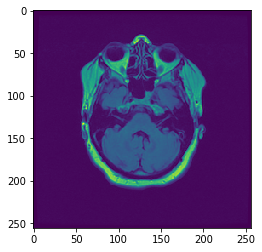

In [26]:
plt.imshow(img)

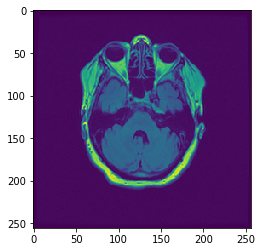

In [27]:
plt.imshow(img2)

In [26]:
def normalize(arr):
    """
    Linear normalization
    http://en.wikipedia.org/wiki/Normalization_%28image_processing%29
    """
    arr = arr.astype('float')
#     # Do not touch the alpha channel
#     for i in range(3):
#         minval = arr[...,i].min()
#         maxval = arr[...,i].max()
#         if minval != maxval:
#             arr[...,i] -= minval
#             arr[...,i] *= (255.0/(maxval-minval))
    minval = np.min(arr)
    maxval = np.max(arr)
    arr -= minval
    arr *= (255.0/(maxval-minval))
    return arr

In [52]:
with open('dcm_arrays/chunk0-1900.pickle', 'rb') as handle:
    dcm_array = pickle.load(handle)
    
X_chunk = dcm_array['x']
Y_chunk = dcm_array['y']
path_chunk = dcm_array['paths']

In [53]:
X_norm = []
for arr in X_chunk:
    norm = normalize(arr) # [:,:,0]
    X_norm.append(norm)

# X_norm = np.array(X_norm)

In [54]:
X_norm = np.array(X_norm)

In [55]:
# l = len(X_norm)
X_norm.shape

(1900, 256, 256, 3)

In [56]:
np.min(X_norm), np.max(X_norm)

(0.0, 255.00000000000003)

# ResNet 50 Tuning

Using a pre-trained ResNet50 model to train a model on mri-images healthy vs PD

In [58]:
sum(Y_chunk), len(Y_chunk)

(1480, 1900)

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, Y_chunk, test_size=0.2)
# X_train, X_test, y_train, y_test = X_norm[:10000], X_norm[10001:], Y[:10000], Y[10001:]

In [61]:
X_train.shape

(1520, 256, 256, 3)

In [62]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [63]:
y_train.shape

(1520, 2)

In [73]:
batch_size = 20
num_classes = 2

In [65]:
base_model = resnet50.ResNet50
#base_model = inception_v3.InceptionV3
# base_model = vgg16.VGG16

base_model = base_model(weights='imagenet', include_top=False, input_shape=(256,256,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.0001),
              metrics=['acc'])


Instructions for updating:
Colocations handled automatically by placer.


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [79]:
filepath="resnet50checkpoints/weights-{epoch:02d}-{acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [80]:
model.fit(X_train, y_train, epochs=10, batch_size = batch_size, callbacks=callbacks_list)

Epoch 1/10
1520/1520 [==============================] - 280s 184ms/step - loss: 0.2644 - acc: 0.8868

Epoch 00001: acc improved from -inf to 0.88684, saving model to resnet50checkpoints/weights-01-0.89.hdf5
Epoch 2/10
1520/1520 [==============================] - 280s 184ms/step - loss: 0.1976 - acc: 0.9263

Epoch 00002: acc improved from 0.88684 to 0.92632, saving model to resnet50checkpoints/weights-02-0.93.hdf5
Epoch 3/10
1520/1520 [==============================] - 280s 184ms/step - loss: 0.1874 - acc: 0.9224

Epoch 00003: acc did not improve from 0.92632
Epoch 4/10
1520/1520 [==============================] - 282s 185ms/step - loss: 0.1290 - acc: 0.9618

Epoch 00004: acc improved from 0.92632 to 0.96184, saving model to resnet50checkpoints/weights-04-0.96.hdf5
Epoch 5/10
1520/1520 [==============================] - 281s 185ms/step - loss: 0.1226 - acc: 0.9612

Epoch 00005: acc did not improve from 0.96184
Epoch 6/10
1520/1520 [==============================] - 281s 185ms/step - los

In [81]:
y_out = model.predict(X_test)

In [83]:
len(y_out), len(X_test)

(380, 380)

In [86]:
mse = 0
for i, val in enumerate(y_out):
    y_pred = np.where(y_out[i]==1)
    y_actual = np.where(y_test[i]==1)
    print(y_pred, y_actual)
    mse += (y_pred[0][0] - y_actual[0][0])**2
    
print('MSE for Stage 1: ', mse/len(y_out))

(array([], dtype=int64),) (array([1]),)


IndexError: index 0 is out of bounds for axis 0 with size 0

In [87]:
y_out

array([[9.07062553e-04, 9.99092937e-01],
       [8.31299549e-05, 9.99916911e-01],
       [3.54968272e-02, 9.64503169e-01],
       [7.86827505e-03, 9.92131770e-01],
       [3.68114322e-01, 6.31885707e-01],
       [1.39882090e-02, 9.86011803e-01],
       [1.08010732e-02, 9.89198983e-01],
       [7.79568970e-01, 2.20431060e-01],
       [2.46758983e-02, 9.75324035e-01],
       [1.68377087e-01, 8.31622958e-01],
       [1.71024213e-03, 9.98289764e-01],
       [1.31312140e-06, 9.99998689e-01],
       [1.08205900e-03, 9.98917937e-01],
       [1.32803374e-03, 9.98672009e-01],
       [7.80905783e-03, 9.92190897e-01],
       [6.26513511e-02, 9.37348664e-01],
       [3.55005264e-02, 9.64499474e-01],
       [6.18284219e-04, 9.99381661e-01],
       [3.84716615e-02, 9.61528361e-01],
       [9.63854080e-04, 9.99036193e-01],
       [7.15770433e-03, 9.92842317e-01],
       [2.28634846e-04, 9.99771416e-01],
       [1.44492788e-02, 9.85550761e-01],
       [2.84073427e-02, 9.71592724e-01],
       [1.634894